# Crowd Layer

In this brief tutorial, we show an example use-case of our package `skactiveml` with the Python package [skorch](https://skorch.readthedocs.io/en/stable/), which is a scikit-learn wrapper for Pytorch models. This way, we are able to implement and test deep learning models in combination with query strategies implemented in our framework.

In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from sklearn.metrics import accuracy_score
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

mlp.rcParams["figure.facecolor"] = "white"

MISSING_LABEL = -1
RANDOM_STATE = 0
FONTSIZE = 12

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings("ignore")

## Loading Music Data Set

In [2]:
data_dir = "./music-multi-annotator-dataset"

In [3]:
X_train = np.load(f'{data_dir}/music-X.npy')
y_train = np.load(f'{data_dir}/music-y.npy')
y_train_true = np.load(f'{data_dir}/music-y-true.npy')
X_valid = np.load(f'{data_dir}/music-X-valid.npy')
y_valid = np.load(f'{data_dir}/music-y-true-valid.npy')
X_test = np.load(f'{data_dir}/music-X-test.npy')
y_test_true = np.load(f'{data_dir}/music-y-true-test.npy')

dataset_classes = np.unique(y_test_true)
n_classes = len(dataset_classes)
n_features = X_train.shape[1]
print(X_train.shape)
print(y_train.shape)

(700, 124)
(700, 44)


## Neural Network Ensemble for tabular data set
In the next step, we define a neural network ensemble for tabular data set

In [4]:
# Define base module.
class ClassifierModule(nn.Module):
    def __init__(self, n_classes, dropout):
        super(ClassifierModule, self).__init__()
        n_hidden_neurons = 128
        self.embed_X_block = nn.Sequential(
            nn.Linear(in_features=124, out_features=n_hidden_neurons),
            nn.BatchNorm1d(num_features=n_hidden_neurons),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )
        self.mlp = nn.Linear(in_features=n_hidden_neurons, out_features=n_classes)

    def forward(self, x):
        
        embed_x = self.embed_X_block(x)
        logit_class = self.mlp(embed_x)       

        # Compute class-membership probabilities.
        p_class = F.softmax(logit_class, dim=-1)

        return p_class

In [5]:
from skactiveml.base import SkactivemlClassifier, AnnotatorModelMixin
from skorch import NeuralNet
from skactiveml.utils import is_labeled, is_unlabeled
from skorch.dataset import Dataset
from skorch.helper import predefined_split

In [6]:
class SkorchClassifier(NeuralNet, SkactivemlClassifier):
    def __init__(
        self,
        module,
        *args,
        classes=None,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=None,
        **module_kwargs,
    ):
        n_classes = len(classes)
        super(SkorchClassifier, self).__init__(
            module,
            *args,
            module__n_classes=n_classes,
            **module_kwargs,
        )
        
        SkactivemlClassifier.__init__(
            self,
            classes=classes,
            missing_label=missing_label,
            cost_matrix=cost_matrix,
            random_state=random_state,
        )
        
        self.regularized = module_kwargs.get("regularized")
        self.lambda1 = module_kwargs.get("lambda1")

    def get_loss(self, y_pred, y_true, *args, **kwargs):
        loss = super(SkorchClassifier, self).get_loss(y_pred, y_true, *args, **kwargs)
        if self.regularized is not None:
            if self.regularized == 1 and self.lambda1 is float:
                loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

    def fit(self, X, y, **fit_params):
        # check input parameters
        self.check_X_dict_ = {
            "ensure_min_samples": 0,
            "ensure_min_features": 0,
            "allow_nd": True,
            "dtype": None,
        }
        X, y, sample_weight = self._validate_data(
            X=X,
            y=y,
            check_X_dict=self.check_X_dict_,
        )

        # check whether model is a valid model

        is_lbld = is_labeled(y, missing_label=self.missing_label)
        try:
            X_lbld = X[is_lbld]
            y_lbld = y[is_lbld].astype(np.int64)
            return super(SkorchClassifier, self).fit(X_lbld, y_lbld, **fit_params)
        except Exception as e:
            self.is_fitted_ = False
            return self

    def initialize(self):
        super(SkorchClassifier, self).check_training_readiness()
        
        super(SkorchClassifier, self)._initialize_virtual_params()
        super(SkorchClassifier, self)._initialize_callbacks()
        super(SkorchClassifier, self)._initialize_module()
        super(SkorchClassifier, self)._initialize_criterion()
        super(SkorchClassifier, self)._initialize_optimizer()
        super(SkorchClassifier, self)._initialize_history()
        
        self.initialized_ = True
        return self

    def predict(self, X):
        return SkactivemlClassifier.predict(self, X)
        

In [7]:
valid_ds = Dataset(X_valid, y_valid)

In [8]:
class CrowdLayerClassifier(SkorchClassifier, AnnotatorModelMixin):
    def __init__(self, *args, **kwargs):
        super(CrowdLayerClassifier, self).__init__(
            module=CrowdLayerModule,
            *args, 
            criterion=CrossEntropyLoss(),
            criterion__reduction="mean",
            criterion__ignore_index=MISSING_LABEL,
            **kwargs,
        )

    def get_loss(self, y_pred, y_true, *args, **kwargs):
        # unpack the tuple from the forward function
        p_class, logits_annot = y_pred
        if len(y_true.shape) != 2:
            return torch.tensor(0) # don't know why
        loss = NeuralNet.get_loss(self, logits_annot, y_true, *args, **kwargs)
        return loss
    
    def fit(self, X, y, **fit_params):
        return NeuralNet.fit(self, X, y, **fit_params)
        
    def predict_annotator_perf(self, X):
        p_class, logits_annot = self.forward(X)
        return logits_annot
    
    def predict(self, X):
        p_class, logits_annot = self.forward(X)
        return p_class.argmax(axis=1)
    
    def predict_proba(self, X):
        p_class, logits_annot = self.forward(X)
        return p_class
    

class CrowdLayerModule(nn.Module):
    def __init__(
        self,
        n_classes,
        n_annotators,
        gt_net,
    ):
        super().__init__()
        self.n_classes = n_classes
        self.n_annotators = n_annotators
        self.gt_net = gt_net

        # Setup crowd layer.
        self.annotator_layers = nn.ModuleList()
        for i in range(n_annotators):
            layer = nn.Linear(n_classes, n_classes, bias=False)
            nn.init.eye_(layer.weight)
            self.annotator_layers.append(layer)

    def forward(self, x):
        """Forward propagation of samples through the GT and AP (optional) model.

        Parameters
        ----------
        x : torch.Tensor of shape (batch_size, *)
            Samples.
        return_logits_annot: bool, optional (default=True)
            Flag whether the annotation logits are to be returned, next to the class-membership probabilities.

        Returns
        -------
        p_class : torch.Tensor of shape (batch_size, n_classes)
            Class-membership probabilities.
        logits_annot : torch.Tensor of shape (batch_size, n_annotators, n_classes)
            Annotation logits for each sample-annotator pair.
        """
        # Compute class-membership logits.
        logit_class = self.gt_net(x)

        # Compute class-membership probabilities.
        p_class = F.softmax(logit_class, dim=-1)

        # Compute logits per annotator.
        logits_annot = []
        for layer in self.annotator_layers:
            logits_annot.append(layer(p_class))
        logits_annot = torch.stack(logits_annot, dim=2)

        return p_class, logits_annot

In [9]:
gt_net = ClassifierModule(n_classes=n_classes, dropout=0.0)

In [10]:
net = CrowdLayerClassifier(
        module__n_annotators=y_train.shape[1],
        module__gt_net=gt_net,
        classes=dataset_classes,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=1,
        train_split=predefined_split(valid_ds),
        max_epochs=200,
        batch_size=16,
        optimizer_lr=0.01,
        verbose=False,
        optimizer=torch.optim.AdamW,
        device=device,
        optimizer__weight_decay=0.01
    )

In [11]:
net.initialize()

<class '__main__.CrowdLayerClassifier'>[initialized](
  module_=CrowdLayerModule(
    (gt_net): ClassifierModule(
      (embed_X_block): Sequential(
        (0): Linear(in_features=124, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.0, inplace=False)
      )
      (mlp): Linear(in_features=128, out_features=10, bias=True)
    )
    (annotator_layers): ModuleList(
      (0-43): 44 x Linear(in_features=10, out_features=10, bias=False)
    )
  ),
)

## Active Classification
For our ensemble, we evaluate four different query strategies, i.e., random sampling, uncertainty sampling, query-by-committee, and batch BALD, regarding their sample selection. For this purpose, we start with ten labels and make 30 iterations of an active learning cycle with a batch size of 32.

In [12]:
# Define setup.
torch.manual_seed(RANDOM_STATE)

net.fit(X_train,y_train)

<class '__main__.CrowdLayerClassifier'>[initialized](
  module_=CrowdLayerModule(
    (gt_net): ClassifierModule(
      (embed_X_block): Sequential(
        (0): Linear(in_features=124, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.0, inplace=False)
      )
      (mlp): Linear(in_features=128, out_features=10, bias=True)
    )
    (annotator_layers): ModuleList(
      (0-43): 44 x Linear(in_features=10, out_features=10, bias=False)
    )
  ),
)

In [34]:
y_pred = net.predict(X_test)
print(y_pred[:20])
print(y_test_true[:20])

print(accuracy_score(y_pred, y_test_true))
# should be 0.785 from MaDL

tensor([5, 2, 2, 9, 5, 9, 8, 5, 5, 2, 9, 2, 8, 2, 9, 9, 2, 2, 9, 2])
[1 8 2 6 1 7 8 1 1 7 3 2 4 2 3 4 7 5 7 8]
0.348


In [35]:
y_train_pred = net.predict(X_train)
print(y_train_pred[:20])
print(y_train_true[:20])
accuracy_score(y_train_true, y_train_pred)

tensor([7, 2, 8, 9, 8, 7, 2, 2, 8, 9, 2, 9, 2, 2, 2, 2, 5, 2, 8, 2])
[4 7 4 7 8 3 2 2 8 3 0 6 7 2 2 0 5 2 8 9]


0.34285714285714286

In [36]:
history = net.history

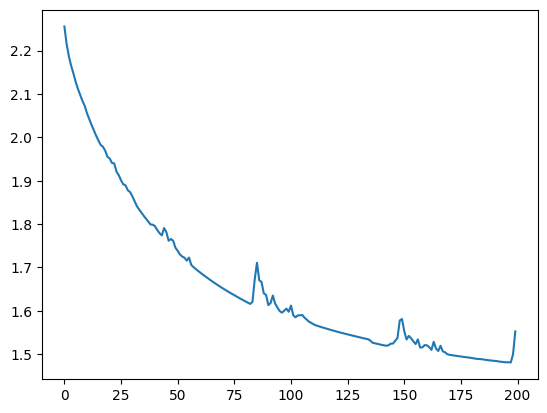

In [37]:
train_loss = history[:, 'train_loss']
plt.plot(train_loss)